In [61]:
import os
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import json
import pandas as pd 
import numpy as np
import check_parameters
import requests
import matplotlib.pyplot as plt

from csv import reader
import re
from datetime import datetime
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set_theme(style="whitegrid");

# making sure that env variables are set - if they are then nothing will print to screen
g.check_environ_variables()

%matplotlib inline

### Niwot Ridge, Colorado, USA

**Station name:** nwot

**Location:** [Niwot Ridge LTER](https://nwt.lternet.edu)

**Archive:** [UNAVCO](https://www.unavco.org)

**Ellipsoidal Coordinates:**

- Latitude: 40.05539 

- Longitude: -105.59053

- Height(m): 3522.729 

[UNAVCO station page](https://www.unavco.org/instrumentation/networks/status/nota/overview/NWOT)


### Data Summary

Station nwot was originally installed/designed by Jim Normandeau (UNAVCO) to support GPS reflections research 
by Kristine Larson, Eric Small, Ethan Gutmann, Felipe Nievinski, and Mark Williams at the University of Colorado. 
The site was hosted by the Niwot Ridge LTER. 

NWOT was deliberately made to be taller than the typical geodetic antenna so that it would never be 
buried by snow. It is approximately 3 meters above 
the bare soil surface.  Because it was installed to support testing GPS reflections, NWOT has always tracked L2C.
nwot was also part of [PBO H2O](http://cires1.colorado.edu/portal/?station=nwot).

<img src="https://www.unavco.org/data/gps-gnss/lib/images/station_images/NWOT.jpg" width=500/>

The site has generally not been used by geodesists and there is very little useful information 
about when data are available at either UNAVCO or Nevada Reno (i.e. no time series).
After the original receiver failed in spring 2015, a new receiver was installed in late 2016 by 
Mark Raleigh (then at CIRES, now at the University Oregon). Though the nwot receiver 
may be tracking now, it has not been downloaded in some time and there is no working telemetry.
We will focus on the data between 2009-2015.

### Make a SNR File and run quickLook

We will start by making a single SNR file. 
Here there are two options. The main archive for this dataset only provides the high-quality
L2C data in the highrate (1-sec) area. We do not need this sample rate for GPS reflectometry,
so to speed things up, we strongly encourage you to use the "special" archive option.  Here
the 1-sec data have been decimated to 15 seconds:

In [63]:
station = 'nwot'
year = 2014 
doy = 270

lat = 40.055
long = -105.591
height = 3522.449

In [4]:
# To understand what rinex2snr returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.rinex2snr?
args = check_parameters.rinex2snr(station, year, doy, archive='special', translator='hybrid')
rnx.run_rinex2snr(**args)

Will seek RINEX file  nwot  year: 2014  doy: 270  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2700.14.snr66


Both L1 and L2C signals can be used at this site, though the L2C data are far superior in quality
to the L1 data. Use this **quickLook** command to get a sense of the quality of the 
reflector height (RH) retrievals. First L1:

In [64]:
# making a plotting function for the quicklook function
def quicklook_results(args, values):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    quadrants = ['NW', 'NE', 'SW', 'SE']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    for i, quadrant in enumerate(quadrants):
        satellites = values[quadrant].keys()
        fail_satellites = values[f'f{quadrant}'].keys()

        for failsat in fail_satellites:
            axes[i].plot(values[f'f{quadrant}'][failsat][0], values[f'f{quadrant}'][failsat][1], color='lightgrey') 
        for sat in satellites:
            axes[i].plot(values[quadrant][sat][0], values[quadrant][sat][1])

    ax[0,0].set_title('Northwest', size=14)
    ax[0,1].set_title('Northeast',size=14)
    ax[1,0].set_title('Southwest', size=14)
    ax[1,1].set_title('Southeast', size=14)

    for ax in axes:
        ax.set_xlabel('reflector height (m)', size=14)
        ax.set_ylabel('volts/volts', size=14)
        ax.grid()
    
    fig.suptitle(f'GNSS Station {args["station"].upper()}, {args["year"]} doy {args["doy"]}, freq L1, elevation angles {args["e1"]}-{args["e2"]} \n', size=16)
    fig.tight_layout()
    plt.show()
    
    
def quicklook_metrics(args, values):
#     fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
    quadrants = ['NW', 'NE', 'SW', 'SE']
    
    # re-organizing the data in a plotting friendly format
    success_data = {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise':[], 'Amplitude': []}
    fail_data =  {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise': [], 'Amplitude': []}
    
    for i, quadrant in enumerate(quadrants):
        for j in values[quadrant].keys():
            success_data['Azimuth'].append(datakeys[quadrant][j][0])
            success_data['Reflector Height'].append(datakeys[quadrant][j][1])
            success_data['Peak to Noise'].append(datakeys[quadrant][j][5])
            success_data['Amplitude'].append(datakeys[quadrant][j][4])
        for k in values[f'f{quadrant}'].keys():
            fail_data['Azimuth'].append(datakeys[f'f{quadrant}'][k][0])
            fail_data['Reflector Height'].append(datakeys[f'f{quadrant}'][k][1])
            fail_data['Peak to Noise'].append(datakeys[f'f{quadrant}'][k][5])
            fail_data['Amplitude'].append(datakeys[f'f{quadrant}'][k][4])

    return pd.DataFrame(success_data), pd.DataFrame(fail_data)   

minimum elevation angle (degrees) for this dataset:  0.0005


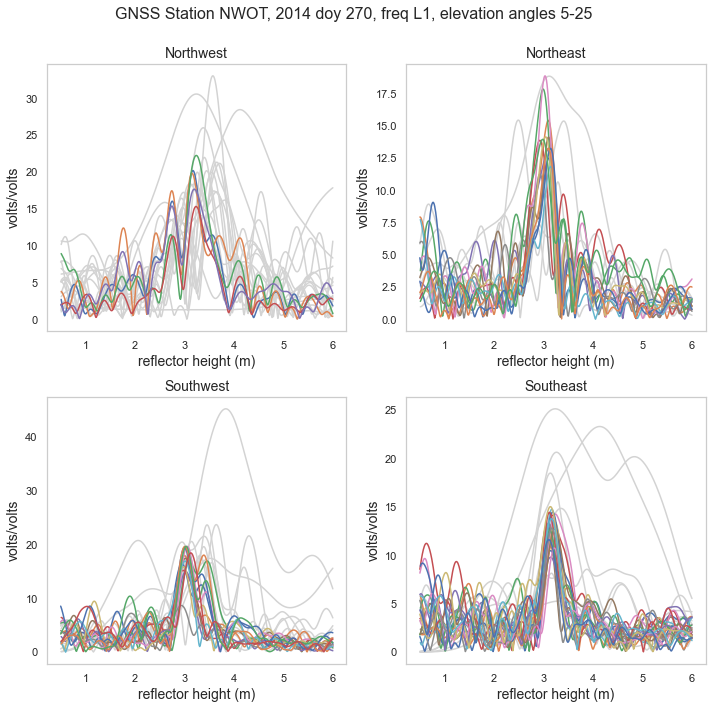

In [65]:
args = check_parameters.quicklook(station, year, doy=doy)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

Average reflector height value: 3.1


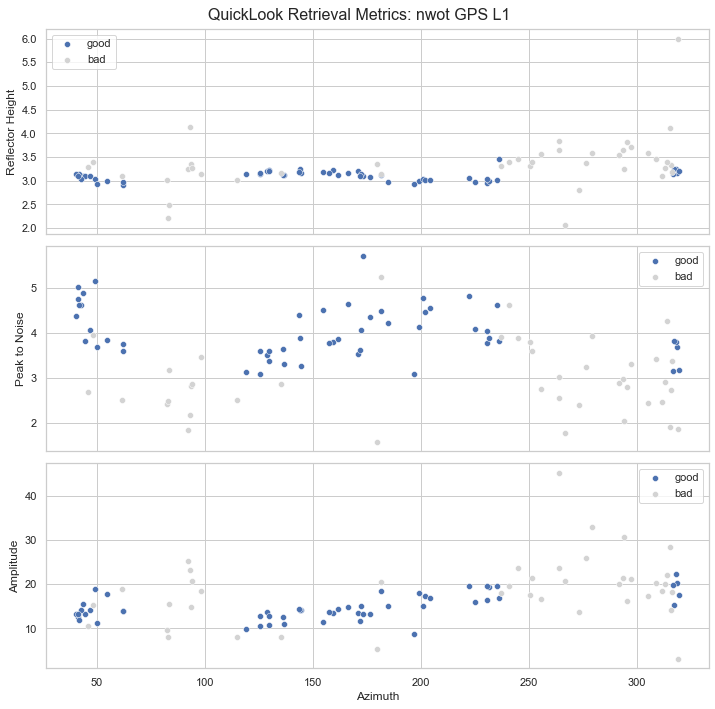

In [66]:
success, fail = quicklook_metrics(args, datakeys)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook Retrieval Metrics: {args["station"]} GPS L1', size=16)

for i, ax in enumerate(axes):
    g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
    g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')
    
# axes[0].legend(loc='upper right')
# avg_rh = np.mean(success['Reflector Height'])
# qc_val_peak2noise = round(min(success['Peak to Noise']))
# axes[1].axhline(qc_val_peak2noise, linestyle='--', color='black', label='QC value used')
# qc_val_amp = round(min(success['Amplitude']))
# axes[2].axhline(qc_val_amp, linestyle='--', color='black', label='QC value used')
print(f'Average reflector height value: {avg_rh:.1f}')
# print('QC value for peak to noise:', qc_val_peak2noise)
# print('QC value for amplitude:', qc_val_amp)

plt.tight_layout()
plt.show()

These periodograms are a bit ratty in the low RH area. There are 
nice strong peaks in the southern quadrants. Now try L2C:

minimum elevation angle (degrees) for this dataset:  0.0005


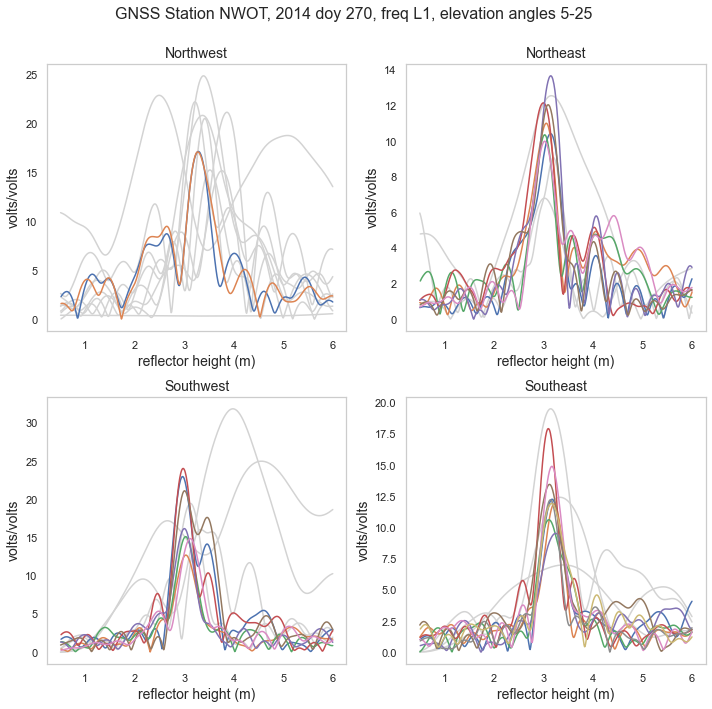

In [69]:
args = check_parameters.quicklook(station, year, doy=doy, f=20)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

Average reflector height value: 3.1


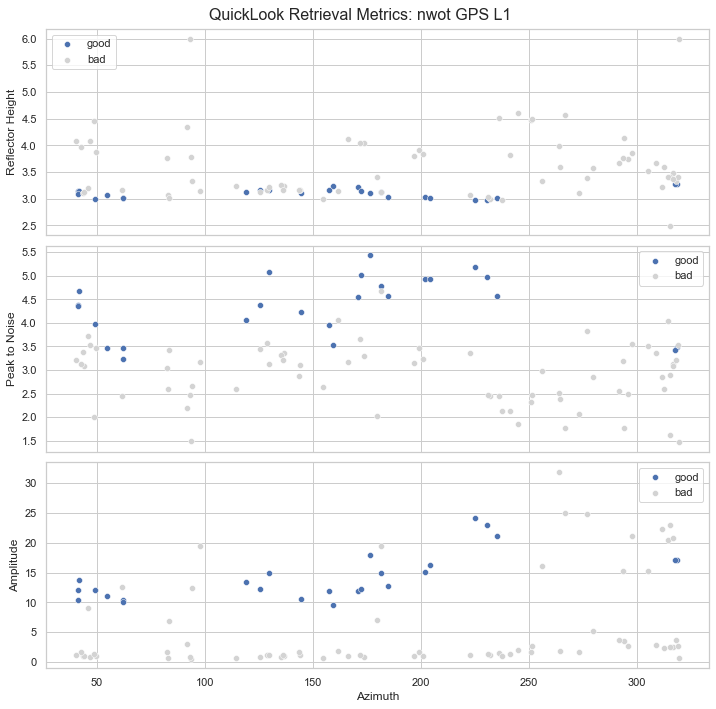

In [68]:
success, fail = quicklook_metrics(args, datakeys)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook Retrieval Metrics: {args["station"]} GPS L1', size=16)

for i, ax in enumerate(axes):
    g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
    g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')
    
# axes[0].legend(loc='upper right')
# avg_rh = np.mean(success['Reflector Height'])
# qc_val_peak2noise = round(min(success['Peak to Noise']))
# axes[1].axhline(qc_val_peak2noise, linestyle='--', color='black', label='QC value used')
# qc_val_amp = round(min(success['Amplitude']))
# axes[2].axhline(qc_val_amp, linestyle='--', color='black', label='QC value used')
print(f'Average reflector height value: {avg_rh:.1f}')
# print('QC value for peak to noise:', qc_val_peak2noise)
# print('QC value for amplitude:', qc_val_amp)

plt.tight_layout()
plt.show()

### Make multiple years of SNR files 

We are going to look at the data from installation (Fall 2009) through Spring 2015. To speed things
up I will run 2009 and 2015 separately, while the year 2010 through 2014 can be analyzed in 
one line:

In [17]:
args = check_parameters.rinex2snr(station, year=2009, doy=240, doy_end=365, archive='special', translator='fortran')
rnx.run_rinex2snr(**args)

args = check_parameters.rinex2snr(station, year=2010, doy=1, doy_end=366, archive='special', year_end=2014, translator='fortran')
rnx.run_rinex2snr(**args)

args = check_parameters.rinex2snr(station, year=2015, doy=1, doy_end=120, archive='special', translator='fortran')
rnx.run_rinex2snr(**args)

Will seek RINEX file  nwot  year: 2009  doy: 240  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2009  doy: 241  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2009  doy: 242  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2009  doy: 243  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2009  doy: 244  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2009  doy: 245  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2450.09.snr66
Will seek RINEX file  nwot



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2840.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 285  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2850.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 286  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2860.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 287  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2870.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 288  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2880.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 289  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3280.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 329  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3290.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 330  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3300.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 331  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3310.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 332  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3320.09.snr66
Will seek RINEX file  nwot  year: 2009  doy: 333  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0070.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 8  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0080.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 9  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0090.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 10  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0100.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 11  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0110.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 12  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/

found it and move to ORBIT area


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0520.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 53  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0530.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 54  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0540.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 55  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0550.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 56  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0560.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 57  translate with  fortran


SUCCESS: SNR file was crea



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0960.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 97  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0970.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 98  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0980.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 99  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0990.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 100  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1000.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 101  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Proje



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1400.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 141  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1410.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 142  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1420.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 143  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1430.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 144  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1440.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 145  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr

found it and move to ORBIT area


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1830.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 184  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1840.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 185  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1850.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 186  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1860.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 187  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1870.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 188  translate with  fortran


SUCCESS: SNR file was



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2270.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 228  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2280.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 229  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2290.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 230  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2300.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 231  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2310.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 232  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2710.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 272  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2720.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 273  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2730.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 274  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2740.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 275  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2750.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 276  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3150.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 316  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3160.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 317  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3170.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 318  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3180.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 319  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3190.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 320  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3580.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 359  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3590.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 360  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3600.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 361  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3610.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 362  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3620.10.snr66
Will seek RINEX file  nwot  year: 2010  doy: 363  translate with  fortran
found it and move to ORBIT area


SUCCESS: SNR file was



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0360.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 37  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0370.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 38  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0380.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 39  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0390.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 40  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0400.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 41  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0800.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 81  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0810.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 82  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0820.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 83  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0830.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 84  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0840.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 85  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1240.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 125  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1250.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 126  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1260.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 127  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1270.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 128  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1280.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 129  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1680.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 169  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1690.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 170  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1700.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 171  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1710.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 172  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1720.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 173  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2120.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 213  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2130.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 214  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2140.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 215  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2150.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 216  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2160.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 217  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2560.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 257  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2570.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 258  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2580.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 259  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2590.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 260  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2600.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 261  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2990.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 300  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3000.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 301  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3010.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 302  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3020.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 303  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3030.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 304  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3430.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 344  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3440.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 345  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3450.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 346  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3460.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 347  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3470.11.snr66
Will seek RINEX file  nwot  year: 2011  doy: 348  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0220.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 23  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0230.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 24  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0240.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 25  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0250.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 26  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0260.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 27  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0660.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 67  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0670.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 68  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0680.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 69  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0690.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 70  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0700.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 71  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1100.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 111  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1110.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 112  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1120.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 113  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1130.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 114  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1140.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 115  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1540.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 155  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1550.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 156  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1560.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 157  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1570.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 158  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1580.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 159  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1980.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 199  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1990.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 200  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2000.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 201  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2010.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 202  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2020.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 203  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr

Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2012  doy: 244  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2012  doy: 245  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2012  doy: 246  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2012  doy: 247  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2012  doy: 248  translate with  fortran
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  nwot  year: 2012  doy: 249  translate with  fortran
Either the RINEX file or orbit file does not exist, so the



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2940.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 295  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2950.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 296  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2960.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 297  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2970.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 298  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2980.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 299  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3380.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 339  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3390.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 340  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3400.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 341  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3410.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 342  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3420.12.snr66
Will seek RINEX file  nwot  year: 2012  doy: 343  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0160.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 17  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0170.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 18  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0180.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 19  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0190.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 20  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0200.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 21  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0600.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 61  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0610.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 62  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0620.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 63  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0630.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 64  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0640.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 65  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1040.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 105  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1050.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 106  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1060.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 107  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1070.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 108  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1080.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 109  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1480.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 149  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1490.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 150  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1500.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 151  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1510.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 152  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1520.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 153  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1920.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 193  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1930.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 194  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1940.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 195  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1950.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 196  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1960.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 197  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2360.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 237  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2370.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 238  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2380.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 239  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2390.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 240  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2400.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 241  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2800.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 281  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2810.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 282  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2820.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 283  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2830.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 284  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2840.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 285  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3240.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 325  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3250.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 326  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3260.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 327  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3270.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 328  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3280.13.snr66
Will seek RINEX file  nwot  year: 2013  doy: 329  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0030.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 4  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0040.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 5  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0050.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 6  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0060.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 7  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0070.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 8  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0470.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 48  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0480.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 49  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0490.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 50  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0500.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 51  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0510.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 52  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0910.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 92  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0920.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 93  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0930.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 94  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0940.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 95  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0950.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 96  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1350.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 136  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1360.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 137  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1370.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 138  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1380.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 139  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1390.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 140  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1790.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 180  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1800.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 181  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1810.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 182  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1820.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 183  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1830.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 184  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2230.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 224  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2240.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 225  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2250.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 226  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2260.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 227  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2270.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 228  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2670.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 268  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2680.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 269  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2690.14.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2700.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 271  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2710.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 272  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2720.14.snr66
Will seek RINEX file  nwot  yea



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3110.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 312  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3120.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 313  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3130.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 314  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3140.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 315  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3150.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 316  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3550.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 356  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3560.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 357  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3570.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 358  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3580.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 359  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3590.14.snr66
Will seek RINEX file  nwot  year: 2014  doy: 360  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0340.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 35  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0350.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 36  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0360.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 37  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0370.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 38  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0380.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 39  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0780.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 79  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0790.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 80  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0800.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 81  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0810.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 82  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0820.15.snr66
Will seek RINEX file  nwot  year: 2015  doy: 83  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project

### Run gnssir for multiple years
Make a json file for your **gnssir** analysis:

In [29]:
check_parameters.make_json(station, lat, long, height, e1=7, peak2noise=3.2, ampl=8)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/nwot.json


I have opted to only use the southern quadrants (azimuths 90 through 270). Note that since
L5 was not tracked at this site, it is not listed in the json file. I am using a minimum elevation
angle of 7 degrees because this particular receiver had a limit on the number of satellites it
could track. In some cases this meant the low elevation data are not available and that triggers
QC restrictions.

In [38]:
# This is the json file that was created
json_file = 'input/nwot.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    file['azval'] = [90, 180, 180, 270]
    file['freqs'] = [1,20]
    file['reqAmp'] = [8,8]
os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'nwot',
 'lat': 40.055,
 'lon': -105.591,
 'ht': 3522.449,
 'minH': 0.5,
 'maxH': 6,
 'e1': 7,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3.2,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [90, 180, 180, 270],
 'freqs': [1, 20],
 'reqAmp': [8, 8],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'nwot_lsp.png',
 'delTmax': 75}

Once you have a json file set up, run gnssir for the years 2009-2015:

In [42]:
check_parameters.gnssir?

In [43]:
year = 2009
doy = 1
doy_end = 365
year_end = 2015 
plt=False
args = check_parameters.gnssir(station, year, doy, doy_end=doy_end, year_end=year_end, plt=plt, screenstats=False)
args
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//065.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot0650.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//066.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot0660.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//067.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot0670.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//068.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot0680.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//069.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//153.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot1530.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//154.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot1540.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//155.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot1550.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//156.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot1560.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//157.txt
Could not read the first SN

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2450.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//246.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2460.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//247.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2470.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//248.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2480.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//249.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2490.09.snr66
Results are written to: /Users/enloe/UNAVCO_Pr

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//285.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2850.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//286.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2860.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//287.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2870.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//288.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot2880.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//289.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//324.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3240.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//325.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3250.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//326.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3260.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//327.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3270.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//328.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//363.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3630.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//364.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3640.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/results/nwot//365.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2009/snr/nwot/nwot3650.09.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//001.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0010.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//002.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0480.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//049.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0490.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//050.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0500.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//051.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0510.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//052.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0520.10.snr66
Results are written to: /Users/enloe/UNAVCO_Pr

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//088.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0880.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//089.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0890.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//090.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0900.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//091.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot0910.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//092.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//127.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1270.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//128.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1280.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//129.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1290.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//130.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1300.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//131.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//166.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1660.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//167.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1670.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//168.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1680.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//169.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot1690.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//170.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//205.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2050.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//206.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2060.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//207.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2070.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//208.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2080.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//209.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//244.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2440.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//245.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2450.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//246.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2460.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//247.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2470.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//248.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//283.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2830.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//284.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2840.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//285.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2850.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//286.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot2860.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//287.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//322.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3220.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//323.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3230.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//324.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3240.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//325.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3250.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//326.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//361.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3610.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//362.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3620.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//363.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3630.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//364.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/snr/nwot/nwot3640.10.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//365.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//035.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0350.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//036.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0360.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//037.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0370.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//038.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0380.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//039.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//074.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0740.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//075.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0750.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//076.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0760.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//077.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot0770.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//078.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//113.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1130.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//114.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1140.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//115.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1150.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//116.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1160.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//117.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//152.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1520.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//153.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1530.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//154.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1540.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//155.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1550.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//156.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//191.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1910.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//192.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1920.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//193.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1930.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//194.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot1940.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//230.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2300.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//231.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2310.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//232.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2320.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//233.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2330.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//234.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//269.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2690.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//270.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2700.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//271.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2710.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//272.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot2720.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//273.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//308.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3080.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//309.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3090.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//310.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3100.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//311.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3110.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//312.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//347.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3470.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//348.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3480.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//349.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3490.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//350.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/nwot/nwot3500.11.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/results/nwot//351.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//021.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0210.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//022.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0220.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//023.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0230.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//024.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0240.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//025.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//060.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0600.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//061.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0610.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//062.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0620.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//063.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0630.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//064.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//099.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot0990.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//100.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1000.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//101.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1010.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//102.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1020.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//103.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//138.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1380.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//139.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1390.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//140.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1400.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//141.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1410.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//142.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//177.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1770.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//178.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1780.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//179.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1790.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//180.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot1800.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//181.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//216.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2160.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//217.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2170.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//218.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2180.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//219.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2190.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//220.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//284.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2840.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//285.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2850.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//286.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2860.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//287.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot2870.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//288.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//323.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3230.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//324.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3240.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//325.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3250.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//326.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3260.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//327.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//362.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3620.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//363.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3630.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//364.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3640.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/nwot//365.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/nwot/nwot3650.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//001.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//036.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0360.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//037.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0370.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//038.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0380.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//039.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0390.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//040.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//075.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0750.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//076.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0760.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//077.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0770.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//078.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot0780.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//079.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//114.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1140.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//115.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1150.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//116.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1160.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//117.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1170.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//118.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//153.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1530.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//154.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1540.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//155.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1550.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//156.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1560.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//157.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//192.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1920.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//193.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1930.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//194.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1940.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot1950.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//196.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//231.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2310.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//232.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2320.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//233.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2330.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//234.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2340.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//235.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//270.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2700.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//271.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2710.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//272.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2720.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//273.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot2730.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//274.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//309.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3090.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//310.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3100.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//311.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3110.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//312.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3120.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//313.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//348.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3480.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//349.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3490.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//350.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3500.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//351.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/nwot/nwot3510.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/nwot//352.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//022.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0220.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//023.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0230.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//024.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0240.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//025.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0250.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//026.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//061.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0610.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//062.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0620.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//063.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0630.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//064.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot0640.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//065.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//100.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1000.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//101.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1010.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//102.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1020.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//103.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1030.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//104.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//139.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1390.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//140.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1400.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//141.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1410.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//142.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1420.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//143.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//178.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1780.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//179.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1790.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//180.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1800.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//181.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot1810.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//182.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//217.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2170.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//218.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2180.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//219.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2190.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//220.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2200.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//221.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//256.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2560.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//257.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2570.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//258.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2580.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//259.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2590.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//260.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//295.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2950.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//296.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2960.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//297.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2970.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//298.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2980.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//299.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//334.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3340.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//335.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3350.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//336.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3360.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//337.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot3370.14.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/results/nwot//338.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//008.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0080.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//009.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0090.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//010.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0100.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//011.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0110.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//012.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//047.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0470.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//048.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0480.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//049.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0490.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//050.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0500.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//051.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//086.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0860.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//087.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0870.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//088.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0880.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//089.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot0890.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//090.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2050.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//206.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2060.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//207.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2070.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//208.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2080.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//209.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2090.15.snr66
Results are

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//288.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2880.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//289.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2890.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//290.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2900.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//291.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/snr/nwot/nwot2910.15.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2015/results/nwot//292.txt
Could not read the first SN

## Compute daily average RH values
Use the daily_avg utility to compute RH for each day. A median filter of 0.25 meter is used
to eliminate large outliers and a minimum number of tracks is set to 10. This is relatively
low because of the small number of L2C transmitting satellites in the early years of
the dataset. The year inputs here are optional.

In [51]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=10, year1=2009, year2=2015, plt2screen=False, txtfile='nwot-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/nwot_allRH.txt
Number of files in  2009 121
not enough retrievals on  2009 9 22 6
not enough retrievals on  2009 12 20 10
not enough retrievals on  2009 12 23 8
not enough retrievals on  2009 12 16 10
not enough retrievals on  2009 11 15 3
Number of files in  2010 347
not enough retrievals on  2010 7 31 10


/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/check_parameters.py:410: UserWarning: loadtxt: Empty input file: "/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//323.txt"
  # putting the results in a np.array, year, doy, RH, Nvalues, month, day


not enough retrievals on  2010 3 24 8
not enough retrievals on  2010 10 19 10
not enough retrievals on  2010 2 16 6
not enough retrievals on  2010 10 17 1
Number of files in  2011 365
Number of files in  2012 315
not enough retrievals on  2012 2 5 9
not enough retrievals on  2012 2 6 10
not enough retrievals on  2012 2 4 5
not enough retrievals on  2012 2 3 6
not enough retrievals on  2012 10 9 5
Number of files in  2013 365
not enough retrievals on  2013 12 19 8
Number of files in  2014 364
not enough retrievals on  2014 1 22 10
not enough retrievals on  2014 1 23 7
not enough retrievals on  2014 1 21 8
not enough retrievals on  2014 1 24 6
not enough retrievals on  2014 1 25 7
not enough retrievals on  2014 1 26 10
Number of files in  2015 119
Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/nwot_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/nwot-dailyavg.txt


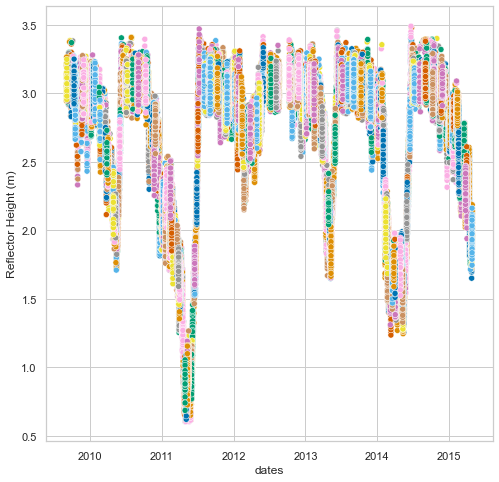

In [52]:
import matplotlib.pyplot as plt
def read_allRH_file(filepath, regex):
    data = {'dates': [], 'rh': []}
    #read daily average reflector heights
    with open(f'{refl_code_dir}{filepath}', 'r') as myfile:
        file = myfile.read()
        matches = re.finditer(regex, file, flags=re.MULTILINE)

        for match in matches:
            ydoy = f'{int(match.group("year"))}-{int(match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j').date()
            data['dates'].append(date)
            data['rh'].append(float(match.group('rh')))
            
    return data

regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim()
g.set_ylabel('Reflector Height (m)');

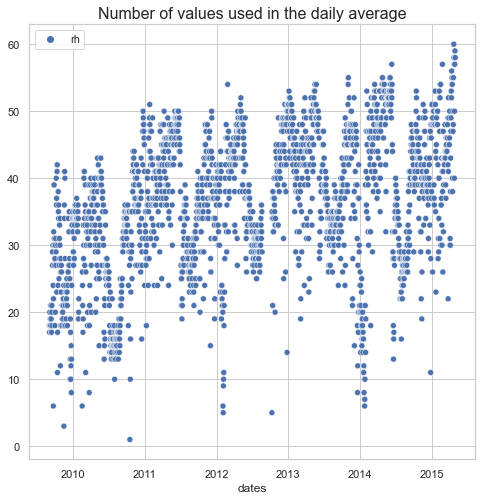

In [53]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

In [54]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

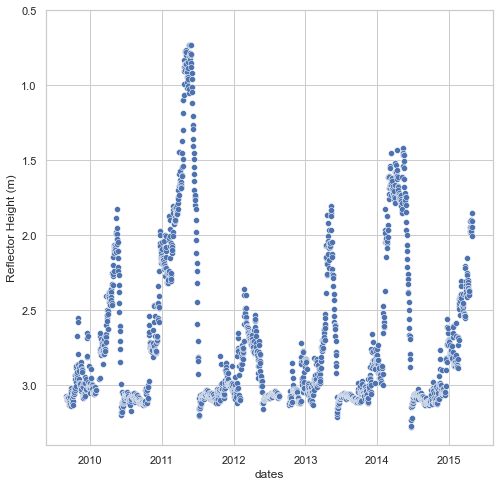

In [59]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(3.4,.5)
g.set_ylabel('Reflector Height (m)');

We installed the GPS site at Niwot Ridge because there was a long-standing experiment 
for measuring snow depth (and snow water equivalent). We therefore have a way to assess
accuracy. We download the *in situ* data from 
the [Niwot Ridge facility.](https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-nwt&identifier=34)
We will compare to pole 16, which is shown in the photograph above. 
The relevant Niwot Ridge csv file is provided here: 

[in situ data from the Niwot Ridge LTER](saddsnow.dw.data.csv)

If the daily average RH file created above is stored in the same directory 
as the Niwot Ridge *in situ* datafile, you can use 
[this python script](nwot_usecase.py) to visually compare them: